In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *


import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.ext.sink import new_sink_particles



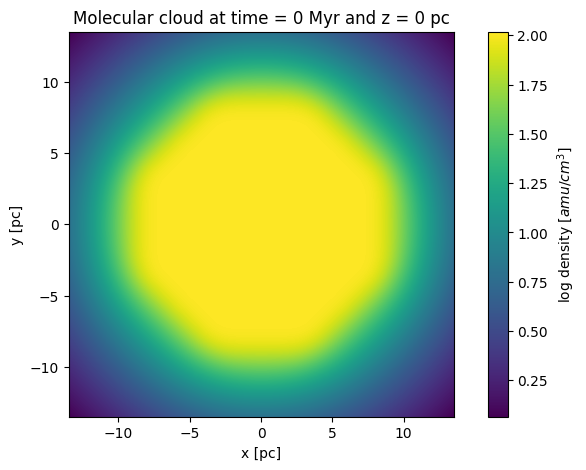

ready for evolution
Time 0.2 Myr
Time 0.4 Myr


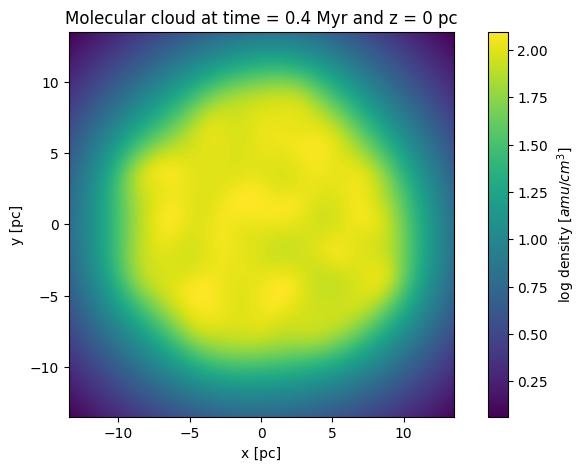

Average mass of a SPH particle 10.362694300518177.


In [2]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 1_000,
                                                         M_cloud = 10_000 | units.MSun,
                                                         R_cloud = 10| units.pc,
                                                         seed = 1312)

particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         t_end = 0.4 | units.Myr, 
                                         dt = 0.2 | units.Myr, 
                                         seed = 1312)

In [3]:
# def hydro_code(Code, dt, converter, particles, seed):
#     '''
#     This function contains the parameters we want to initialise the 
#     hydro code with. (hard Coded)
#     '''
    
#     np.random.seed(seed)

#     hydro = Code(converter)
#     hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
#                             # SPH hydro included, False means: gravity only.
#     hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
#                         # (default value:1.6666667). In this case-> Ideal Gas   
#     hydro.parameters.timestep = dt
#     hydro.parameters.eps_is_h_flag = True # Default value
#     hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
#     hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
#                 # isothermal gas (requires integrate_entropy_flag == False)
#     hydro.parameters.integrate_entropy_flag = False #True means: integrate
#                                           # entropy, else: internal energy. 
#     hydro.gas_particles.add_particles(particles) # add the particles
   
#     return hydro 

In [4]:
np.mean(particles_cloud.density)


quantity<1.48971323945e-19 m**-3 * kg>

In [5]:
# initialise the star particle set
star = Particles(1)
star.name = "star"
star.mass = 500 |units.MSun
star.radius = 0.25 | units.pc
star.position = (-1.0, 0, 0) * (0 | units.pc)
# star.velocity = (1.0, 0, 0) * (vorb.in_(units.kms))
star.velocity = (1.0, 0, 0) * (0| units.kms)

converter_star = nbody_system.nbody_to_si(star.mass.sum(), 
                                   star.position.sum())

In [6]:
# #start the hydro code for the gas
# hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
#                          converter = converter_cloud,
#                          particles = particles_cloud,
#                          seed = 1312)

# start the gravity code for the star
gravity_code = Bhtree(converter_star)
sink = new_sink_particles(star)
gravity_code.particles.add_particles(sink)

channel = {"to_star": gravity_code.particles.new_channel_to(sink),
           "from_star": sink.new_channel_to(gravity_code.particles)}
        #    "to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
        #     "from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:134: RuntimeWarning: divide by zero encountered in log
  log_factors_of_the_bases = numpy.log(numpy.abs(factors_of_the_bases))
/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:137: RuntimeWarning: invalid value encountered in matmul
  numpy.matmul(self.new_base_inv, log_factors_of_the_bases)
/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:234: RuntimeWarning: divide by zero encountered in scalar divide
  factor = factor / (unit_in_si.factor ** n)
/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:238: RuntimeWarning: invalid value encountered in multiply
  return new_quantity(number * factor, new_unit)
/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:234: Run

In [7]:
def sound_speed(temp,mean_molecular_mass):
    temp = temp | units.K
    k = units.constants.kB
    molecular_weight = mean_molecular_mass | units.amu
    sound_speed =(k*temp/molecular_weight).sqrt()

    return sound_speed
    
    
def bondi_radius(sound_speed,stellar_mass):
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)

    return R

def bondi_accretion_rate(rho,v,r):
    dM = units.constants.pi * (r**2) * rho * v

    return dM

# def accrete_particles(sink,cloud,bondi_radius):
    
#     # for particles in cloud:
#     #     separation = particles.position - source.position
#     #     dist = separation.length()
#     #     accretion_radius = bondi_radius
#     #     if dist < accretion_radius:
#             ini_mass = sink.mass
#             source.accrete(cloud)
#             mass = sink.mass-ini_mass
#             print("particles accreted with mass", mass)
                
#         accreted_gas = gas_particle.select_array(lambda d: d < accretion_radius)
#         sink.accrete(accreted_gas)
#         cloud.remove_particles(accreted_gas)

    

In [11]:
t_end = 5 | units.Myr
model_time = 0 | units.Myr
dt = 0.2 | units.Myr

L = int(abs(sink.position.sum().value_in(units.pc)))*1.2
N = 500

while model_time < t_end:

    print('Sink in progress at', model_time.value_in(units.Myr), ' Myr')

    # for particles in particles_cloud:
    #     separation = particles.position - sink.position
    #     dist = separation.length()
    #     accretion_radius = bondi_radius(cs,mass = sink.mass)

    #     if dist < accretion_radius:
    #         sink.accrete(particles_cloud)
    #         particles_cloud.remove_particle(particles)
    #         print('Particle accreted')
    
    accreted_gas = sink.accrete_looping_over_sources(particles_cloud)
    sink.accrete(accreted_gas)
    particles_cloud.remove_particles(accreted_gas)
    #sink.aggregate_mass(accreted_gas)

    print(sink.mass - star.mass)

    gravity_code.evolve_model(model_time)
    # update channels
    channel["to_star"].copy()



        
    channel["from_star"].copy()
    model_time += dt



Sink in progress at 0  Myr
[0.0] MSun
Sink in progress at 0.2  Myr
[nan] MSun


/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:238: RuntimeWarning: invalid value encountered in scalar multiply
  return new_quantity(number * factor, new_unit)
/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:196: RuntimeWarning: divide by zero encountered in scalar power
  factor = factor * (unit_in_si.factor ** n)
/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:196: RuntimeWarning: invalid value encountered in scalar multiply
  factor = factor * (unit_in_si.factor ** n)
/media/ulk/code/environments/Amuse-env/lib/python3.10/site-packages/amuse/units/generic_unit_converter.py:200: RuntimeWarning: invalid value encountered in multiply
  return new_quantity(number * factor, new_unit)


In [ ]:
gravity_code.stop()
hydro_cloud.stop()
gravhydrobridge.stop()

In [ ]:
print(sink.mass.value_in(units.kg))